# Aprendizaje supervisado: Riesgo crediticio #

In [4]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("adilshamim8/credit-risk-benchmark-dataset")

print("Path to dataset files:", path)

c:\Users\Alejo\AppData\Local\Programs\Python\Python312\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Path to dataset files: C:\Users\Alejo\.cache\kagglehub\datasets\adilshamim8\credit-risk-benchmark-dataset\versions\1


# Pre procesamiento y limpieza de datos #

- En esta sección, se procede a la carga del dataset descargado desde Kaggle. Posteriormente, se realiza una inspección de valores nulos en cada columna. Para simplificar el análisis y evitar sesgos por imputación, se eliminan las observaciones con datos faltantes. Finalmente, se revisa un resumen estadístico de las variables numéricas para entender mejor la distribución de los datos.

In [5]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import matplotlib
matplotlib.use('Agg') 
import matplotlib.pyplot as plt
plt.switch_backend('Agg')  
%matplotlib inline  

import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, roc_curve, auc
from sklearn.inspection import permutation_importance

sns.set(style='whitegrid')

print('Libraries imported and setup complete.')

Libraries imported and setup complete.


In [6]:
import os
carpeta = "C:\\Users\\Alejo\\.cache\\kagglehub\\datasets\\adilshamim8\\credit-risk-benchmark-dataset\\versions\\1"
print("Archivos en la carpeta:")
print(os.listdir(carpeta))

Archivos en la carpeta:
['Credit Risk Benchmark Dataset.csv']


In [ ]:
file_path = os.path.join(carpeta, "Credit Risk Benchmark Dataset.csv") 
df = pd.read_csv(file_path)

print("Primeras filas del DataFrame:")
print(df.head())

Primeras filas del DataFrame:
   rev_util   age  late_30_59  debt_ratio  monthly_inc  open_credit  late_90  \
0  0.006999  38.0         0.0    0.302150       5440.0          4.0      0.0   
1  0.704592  63.0         0.0    0.471441       8000.0          9.0      0.0   
2  0.063113  57.0         0.0    0.068586       5000.0         17.0      0.0   
3  0.368397  68.0         0.0    0.296273       6250.0         16.0      0.0   
4  1.000000  34.0         1.0    0.000000       3500.0          0.0      0.0   

   real_estate  late_60_89  dependents  dlq_2yrs  
0          1.0         0.0         3.0         0  
1          1.0         0.0         0.0         0  
2          0.0         0.0         0.0         0  
3          2.0         0.0         0.0         0  
4          0.0         0.0         1.0         0  


In [8]:
print('Missing values in each column:')
print(df.isnull().sum())
df_clean = df.dropna()
print('\nShape after dropping missing values:', df_clean.shape)

print('\nStatistical summary:')
print(df_clean.describe())

Missing values in each column:
rev_util       0
age            0
late_30_59     0
debt_ratio     0
monthly_inc    0
open_credit    0
late_90        0
real_estate    0
late_60_89     0
dependents     0
dlq_2yrs       0
dtype: int64

Shape after dropping missing values: (16714, 11)

Statistical summary:
           rev_util           age    late_30_59    debt_ratio    monthly_inc  \
count  16714.000000  16714.000000  16714.000000  16714.000000   16714.000000   
mean       4.799862     48.798672      1.110267     30.980298    6118.120258   
std      204.062345     13.906078      7.172890    719.694859    5931.841779   
min        0.000000     21.000000      0.000000      0.000000       0.000000   
25%        0.082397     38.000000      0.000000      0.155971    3128.500000   
50%        0.443080     48.000000      0.000000      0.322299    5000.000000   
75%        0.926637     58.000000      1.000000      0.533426    7573.000000   
max    22000.000000    101.000000     98.000000  61106.50

## Realización de  mini EDA ##

Con los datos limpios, se procede a realizar un análisis exploratorio con el objetivo de comprender el comportamiento de las variables más relevantes. Se examinan estadísticas descriptivas como la media, mediana, desviación estándar y valores extremos. Esto permite detectar posibles asimetrías, variaciones significativas entre observaciones, así como identificar variables que podrían requerir transformación o normalización. También se analiza visualmente la distribución de la variable dependiente para verificar si existe un desbalance entre clases, lo cual es un factor importante a tener en cuenta al momento de construir los modelos predictivos. Adicionalmente, se exploran relaciones entre variables mediante gráficos de dispersión, correlaciones y diagramas de caja para entender la dinámica entre los factores de riesgo y la ocurrencia de moras graves.

In [9]:
print('\nResumen estadístico:')
print(df_clean.describe())


Resumen estadístico:
           rev_util           age    late_30_59    debt_ratio    monthly_inc  \
count  16714.000000  16714.000000  16714.000000  16714.000000   16714.000000   
mean       4.799862     48.798672      1.110267     30.980298    6118.120258   
std      204.062345     13.906078      7.172890    719.694859    5931.841779   
min        0.000000     21.000000      0.000000      0.000000       0.000000   
25%        0.082397     38.000000      0.000000      0.155971    3128.500000   
50%        0.443080     48.000000      0.000000      0.322299    5000.000000   
75%        0.926637     58.000000      1.000000      0.533426    7573.000000   
max    22000.000000    101.000000     98.000000  61106.500000  250000.000000   

        open_credit       late_90   real_estate    late_60_89    dependents  \
count  16714.000000  16714.000000  16714.000000  16714.000000  16714.000000   
mean       8.503709      0.863827      1.047445      0.734354      0.944358   
std        5.370965 

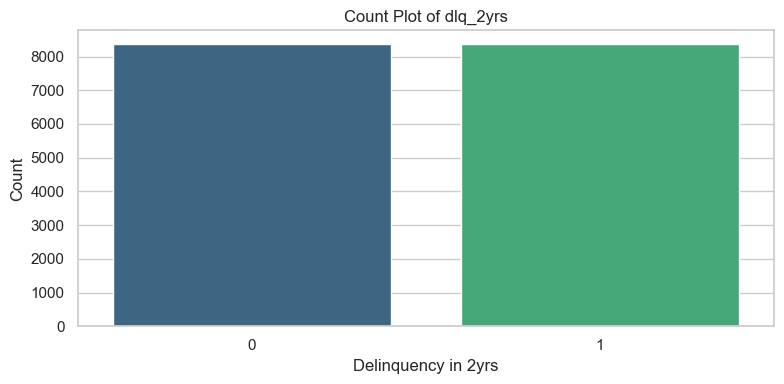

In [10]:
plt.figure(figsize=(8, 4))
sns.countplot(x='dlq_2yrs', data=df_clean, palette='viridis')
plt.title('Count Plot of dlq_2yrs')
plt.xlabel('Delinquency in 2yrs')
plt.ylabel('Count')
plt.tight_layout()
plt.show()

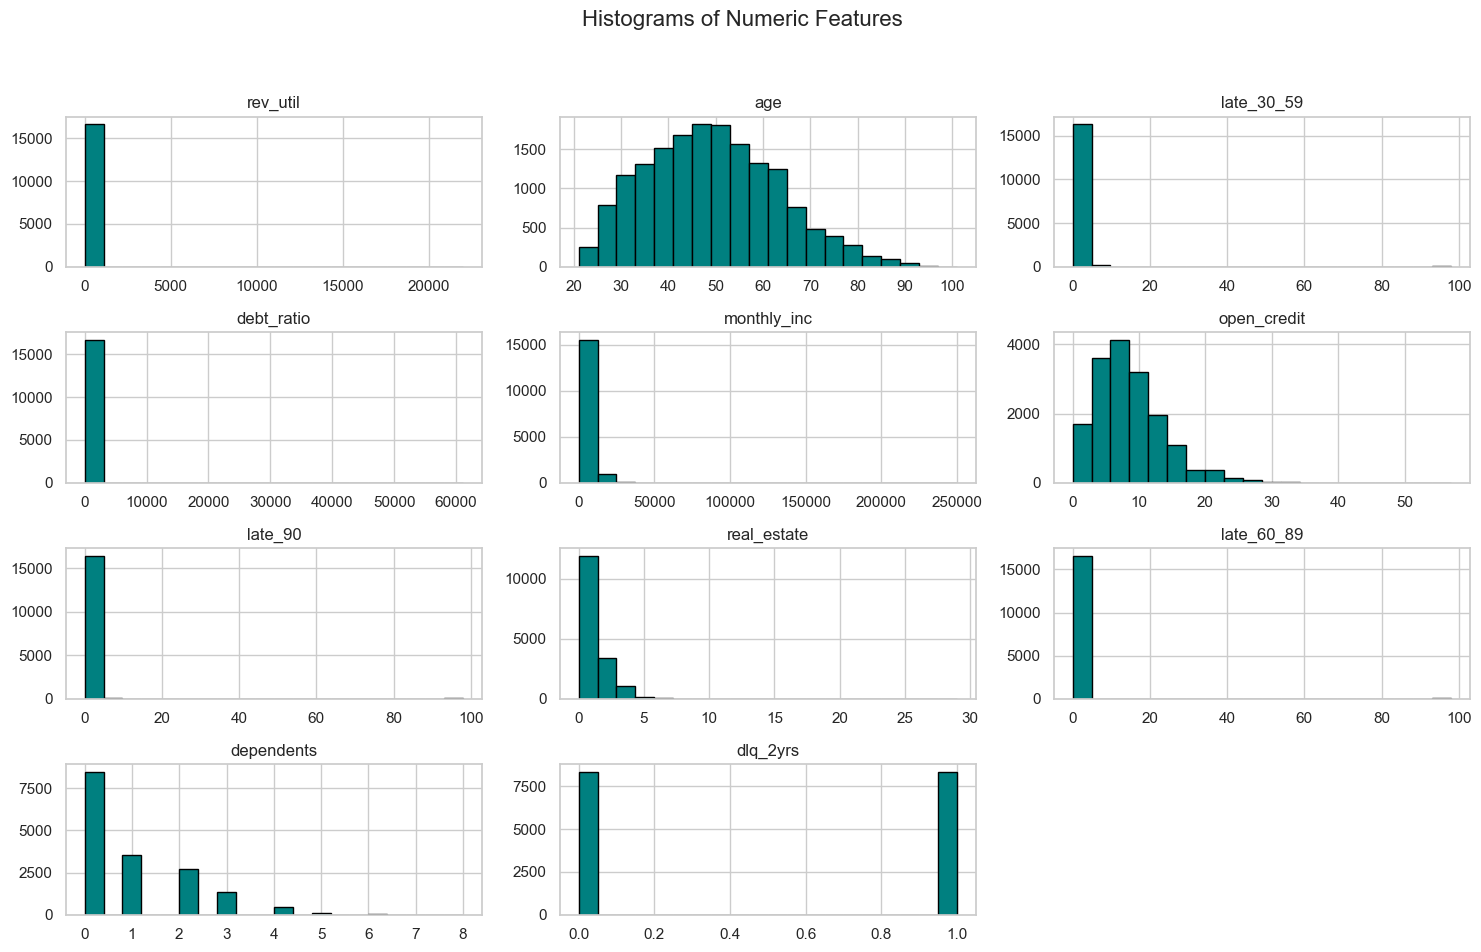

In [11]:
df_clean.hist(bins=20, figsize=(15, 10), color='teal', edgecolor='black')
plt.suptitle('Histograms of Numeric Features', fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

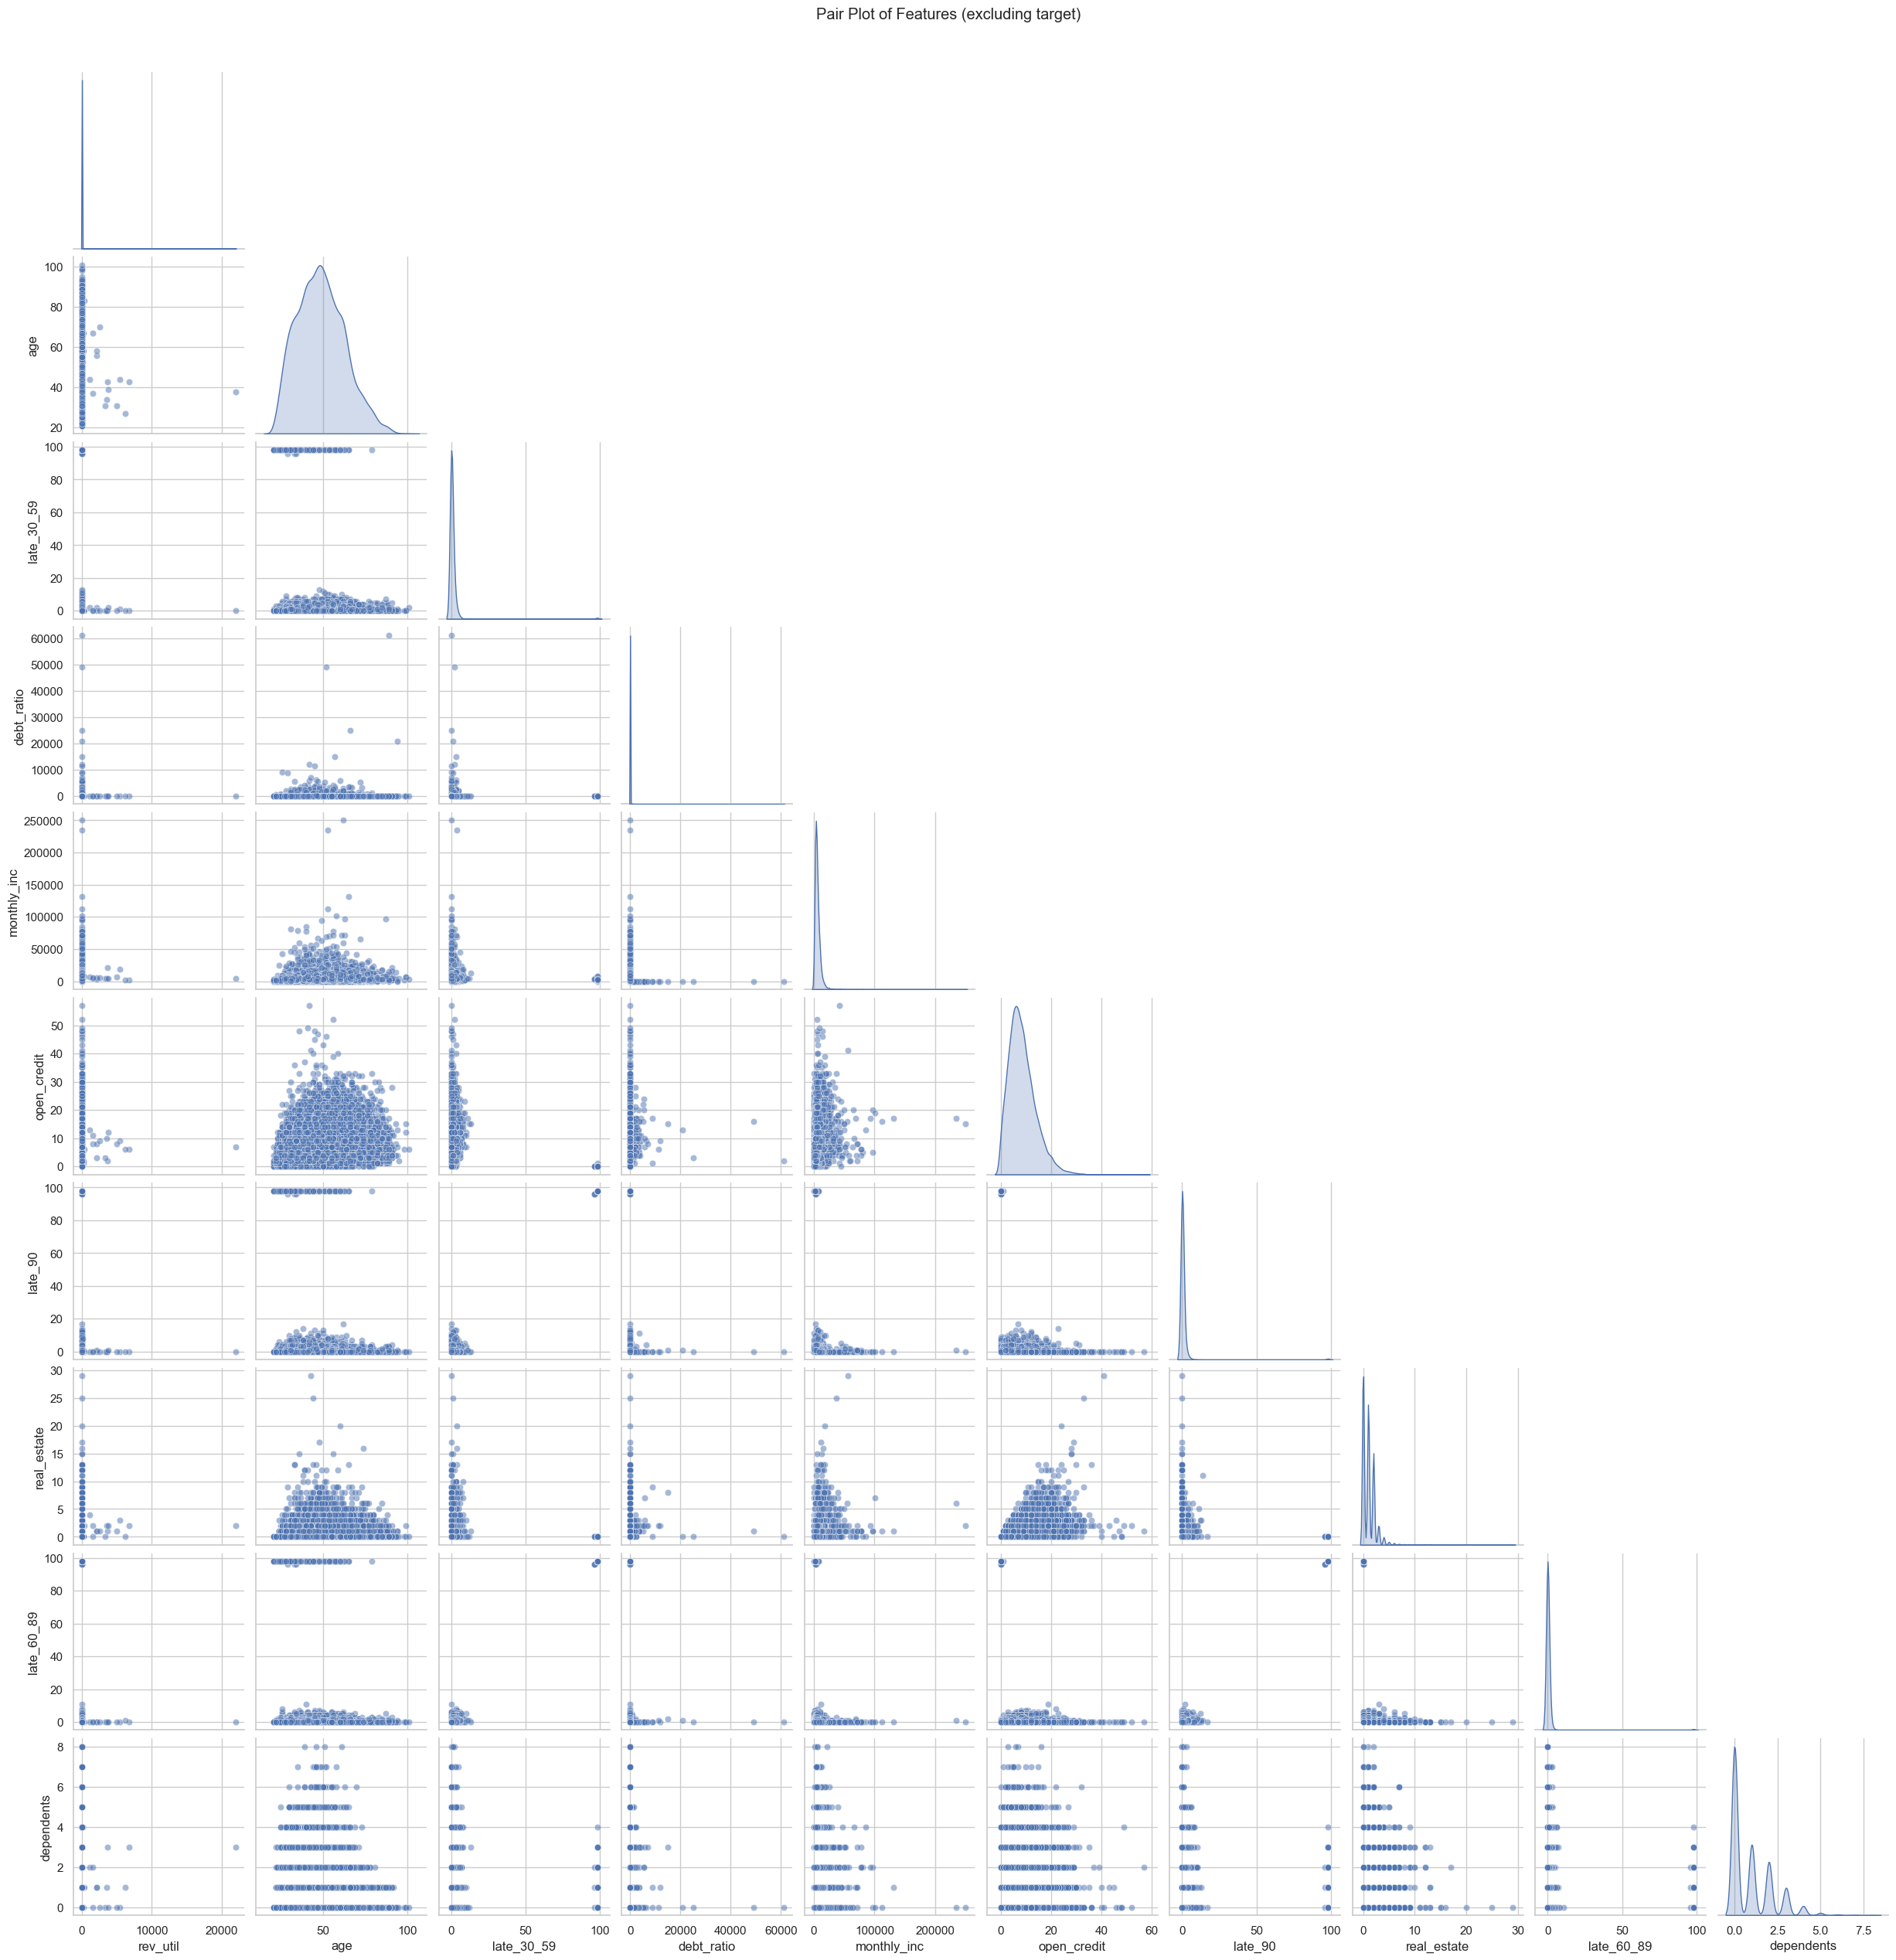

In [12]:
sns.pairplot(df_clean, diag_kind='kde', corner=True, plot_kws={'alpha':0.5}, 
             vars=df_clean.columns.drop('dlq_2yrs'))
plt.suptitle('Pair Plot of Features (excluding target)', y=1.02)
plt.show()

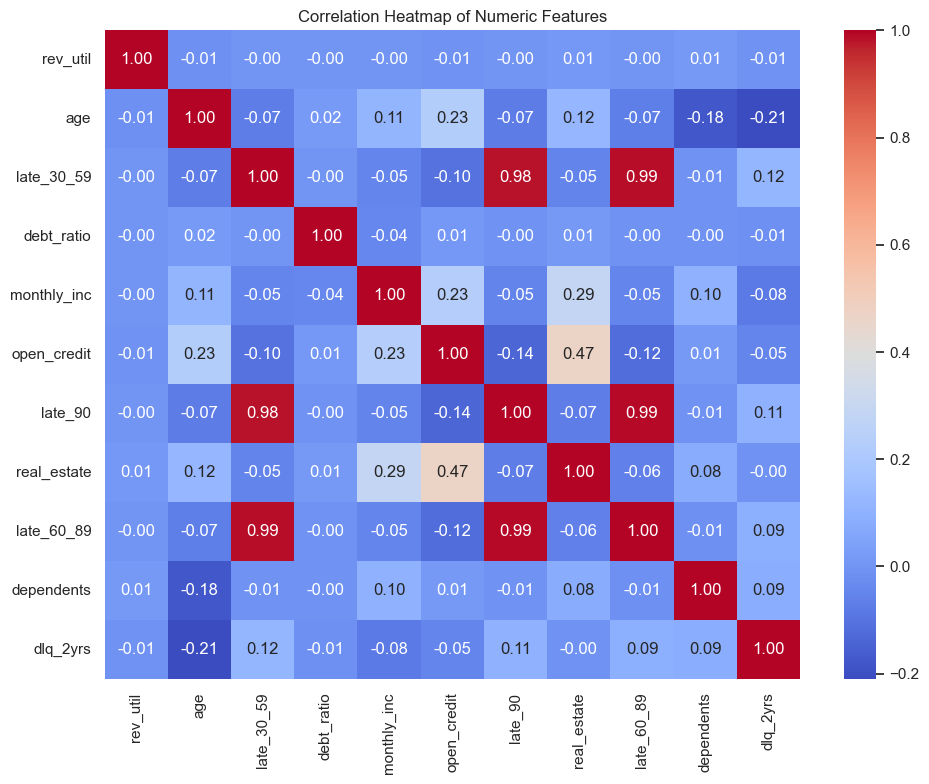

In [13]:
numeric_df = df_clean.select_dtypes(include=[np.number])
if numeric_df.shape[1] >= 4:
    plt.figure(figsize=(10,8))
    corr = numeric_df.corr()
    sns.heatmap(corr, annot=True, cmap='coolwarm', fmt='.2f')
    plt.title('Correlation Heatmap of Numeric Features')
    plt.tight_layout()
    plt.show()
else:
    print('Not enough numeric columns for a correlation heatmap.')

# Modelos de predicción #

- Árbol de decisión 
- Modelo de regresión 
- KNN

## Modelo de regresión logística ##

Con el propósito de modelar la probabilidad de que un individuo incurra en mora grave (dlq_2yrs), se implementa una regresión logística, la cual es adecuada dado que la variable dependiente es binaria. Este modelo estima la probabilidad de ocurrencia del evento en función de un conjunto de predictores, mediante la función logística. Se entrena el modelo sobre los datos limpios y particionados, y se evalúa su capacidad predictiva mediante métricas como la exactitud, matriz de confusión y el área bajo la curva ROC. Este enfoque permite interpretar la dirección y significancia estadística del efecto de cada variable sobre la probabilidad de incumplimiento, lo cual aporta valor explicativo al análisis de riesgo crediticio.



Accuracy of the Logistic Regression model: 0.7295842058031708


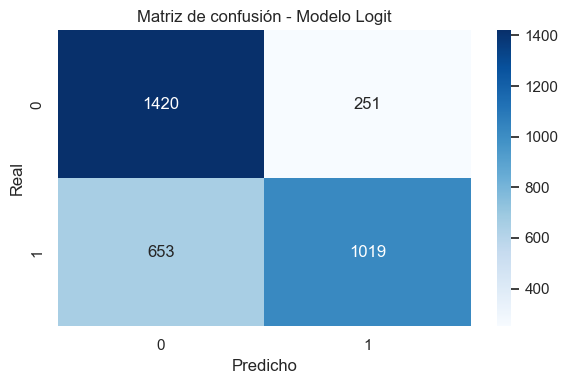

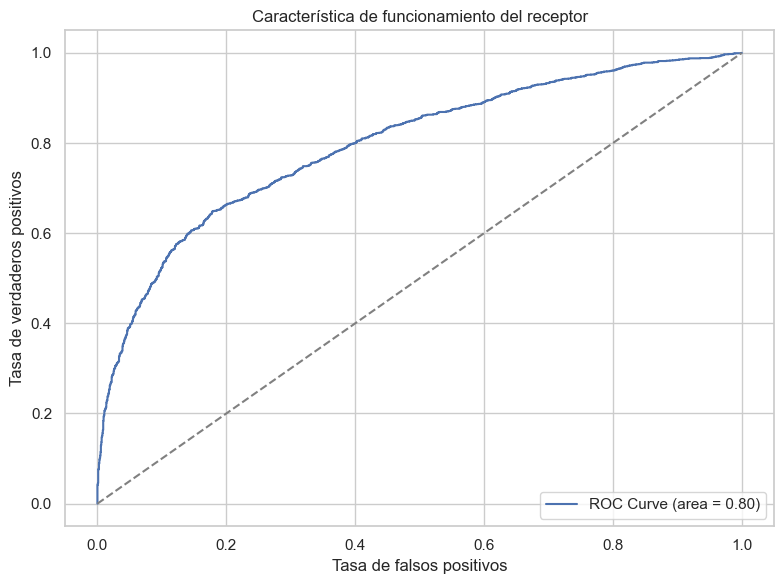


Permutation Importance:


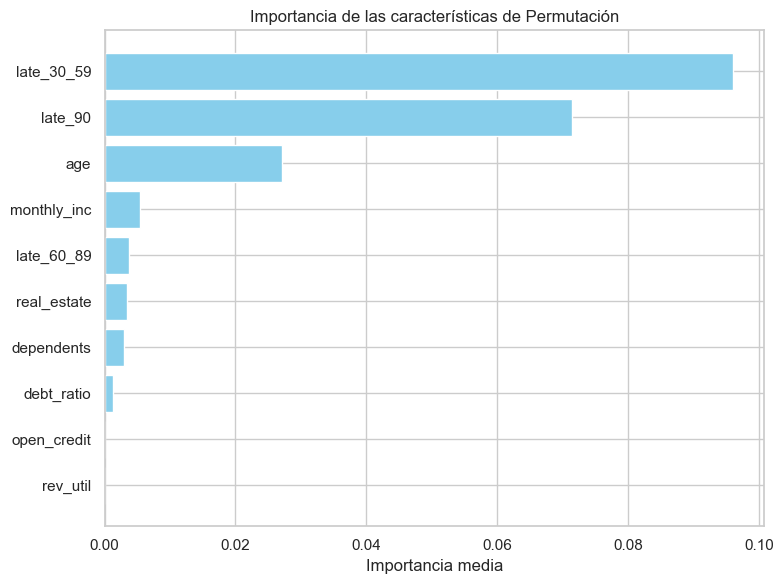

In [14]:
X = df_clean.drop('dlq_2yrs', axis=1)
y = df_clean['dlq_2yrs']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = LogisticRegression(max_iter=1000)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

acc = accuracy_score(y_test, y_pred)
print('Accuracy of the Logistic Regression model:', acc)

cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Matriz de confusión - Modelo Logit')
plt.xlabel('Predicho')
plt.ylabel('Real')
plt.tight_layout()
plt.show()

y_prob = model.predict_proba(X_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label='ROC Curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel('Tasa de falsos positivos')
plt.ylabel('Tasa de verdaderos positivos')
plt.title('Característica de funcionamiento del receptor')
plt.legend(loc='lower right')
plt.tight_layout()
plt.show()

print('\nPermutation Importance:')
result = permutation_importance(model, X_test, y_test, n_repeats=10, random_state=42, n_jobs=-1)
importances = result.importances_mean
indices = np.argsort(importances)

plt.figure(figsize=(8, 6))
plt.barh(range(len(indices)), importances[indices], color='skyblue')
plt.yticks(range(len(indices)), [X_test.columns[i] for i in indices])
plt.xlabel('Importancia media')
plt.title('Importancia de las características de Permutación')
plt.tight_layout()
plt.show()

## Modelo de árbol de decisión ##

Se construye un modelo de árbol de decisión como alternativa no paramétrica para la predicción del evento de mora. Este tipo de modelo segmenta el espacio de predictores en regiones homogéneas con base en reglas de decisión jerárquicas que maximizan la pureza de las clases. Su estructura es altamente interpretable y permite identificar de forma visual las combinaciones de características que conducen a un mayor riesgo crediticio. Además, permite manejar relaciones no lineales y detectar interacciones entre variables sin necesidad de especificarlas previamente. La evaluación del desempeño del árbol se realiza mediante medidas de clasificación y análisis gráfico de la estructura del modelo.

Accuracy del árbol de decisión: 0.7580017947950942


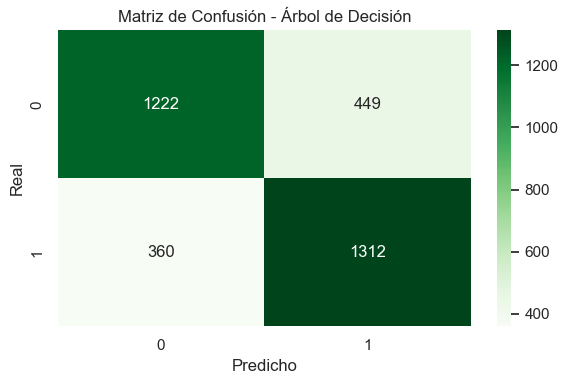


Reporte de clasificación:
              precision    recall  f1-score   support

           0       0.77      0.73      0.75      1671
           1       0.75      0.78      0.76      1672

    accuracy                           0.76      3343
   macro avg       0.76      0.76      0.76      3343
weighted avg       0.76      0.76      0.76      3343



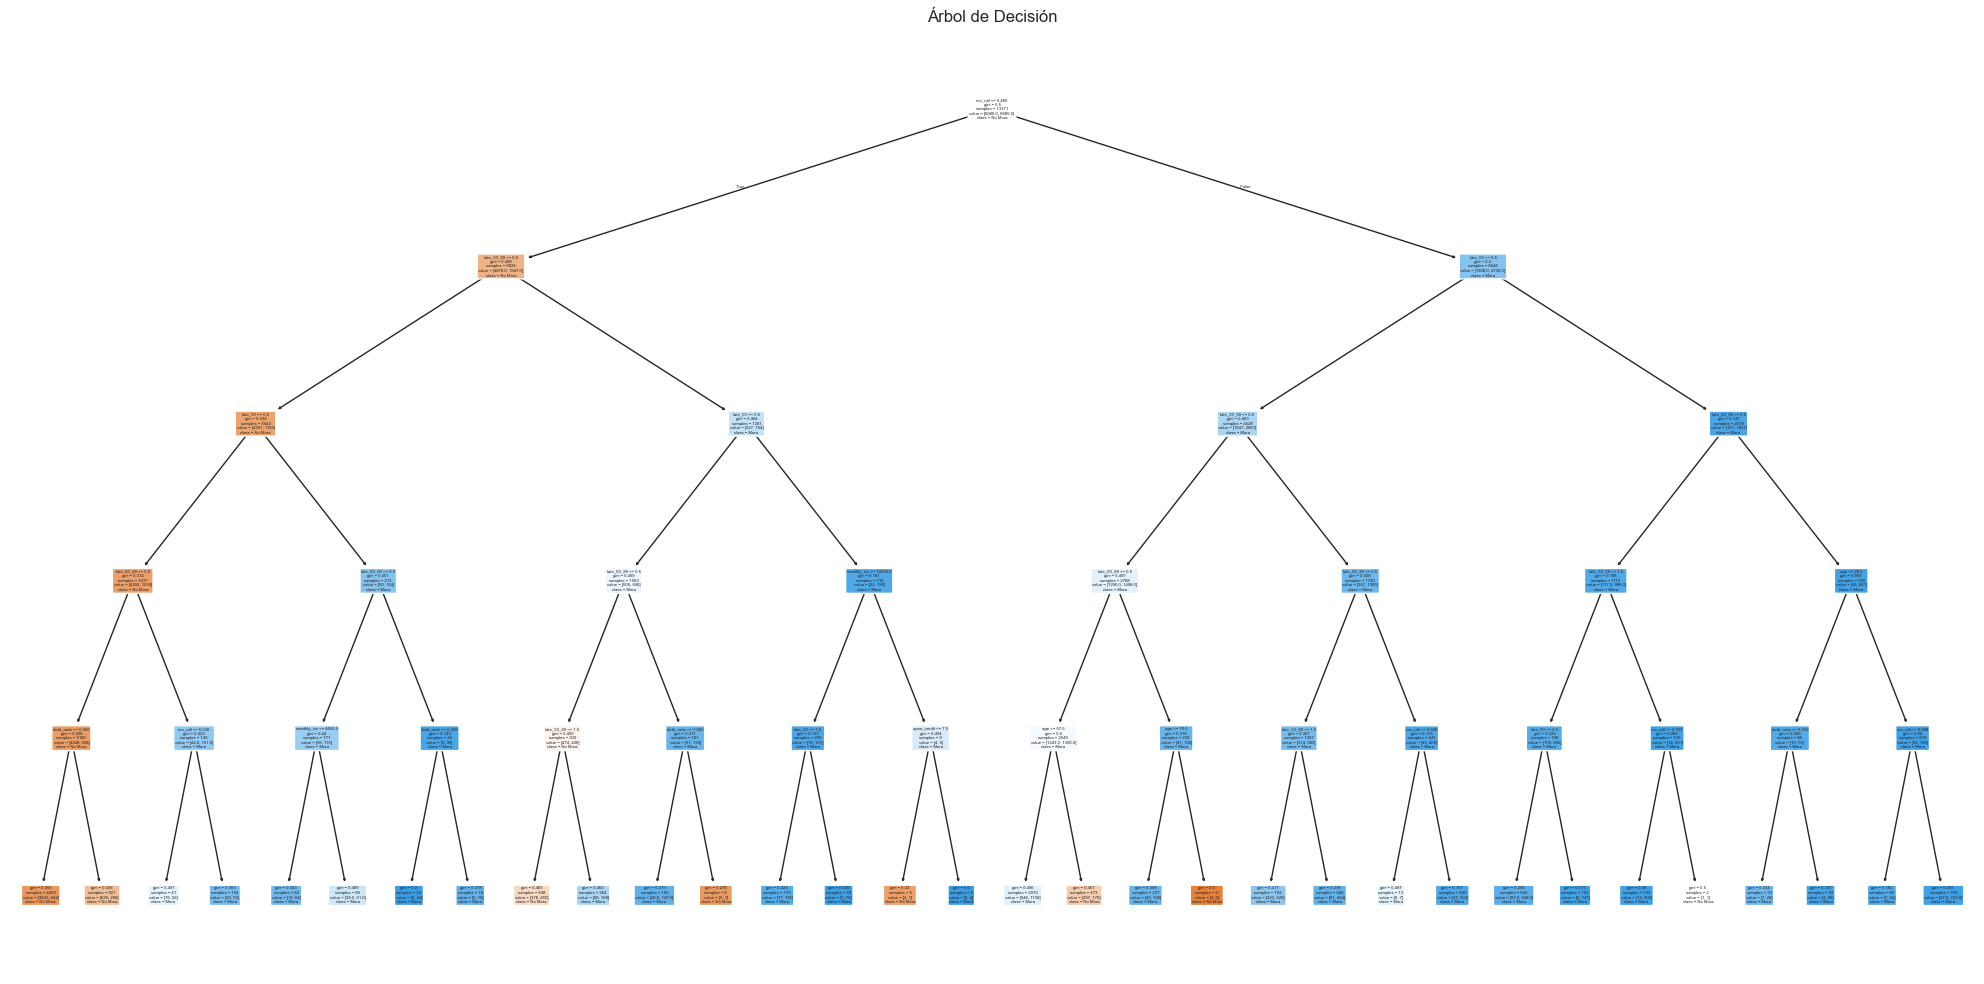

In [15]:
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

# 1. Definir variables predictoras y objetivo
X = df_clean.drop('dlq_2yrs', axis=1)
y = df_clean['dlq_2yrs']

# 2. Dividir el conjunto de datos (80% entrenamiento, 20% prueba)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 3. Inicializar y ajustar el árbol de decisión
tree_model = DecisionTreeClassifier(max_depth=5, random_state=42)
tree_model.fit(X_train, y_train)

# 4. Predecir en el conjunto de prueba
y_pred_tree = tree_model.predict(X_test)

# 5. Evaluar desempeño
accuracy_tree = accuracy_score(y_test, y_pred_tree)
print("Accuracy del árbol de decisión:", accuracy_tree)

# 6. Matriz de confusión
cm_tree = confusion_matrix(y_test, y_pred_tree)
plt.figure(figsize=(6, 4))
sns.heatmap(cm_tree, annot=True, fmt='d', cmap='Greens')
plt.title('Matriz de Confusión - Árbol de Decisión')
plt.xlabel('Predicho')
plt.ylabel('Real')
plt.tight_layout()
plt.show()

# 7. Reporte de clasificación
print("\nReporte de clasificación:")
print(classification_report(y_test, y_pred_tree))

# 8. Visualizar el árbol
plt.figure(figsize=(20, 10))
plot_tree(tree_model, feature_names=X.columns, class_names=['No Mora', 'Mora'], filled=True, rounded=True)
plt.title('Árbol de Decisión')
plt.tight_layout()
plt.show()


## Modelo KNN ##

Para complementar el análisis predictivo, se implementa un modelo de vecinos más cercanos (KNN), el cual clasifica una observación nueva con base en la mayoría de clases entre sus k vecinos más cercanos en el espacio de características. Debido a su sensibilidad a la escala, se aplica normalización previa de los datos. Este modelo no requiere suposición de forma funcional entre las variables y se apoya exclusivamente en la similitud entre observaciones, lo que lo hace útil en contextos donde las relaciones pueden ser complejas o no lineales. Se evalúa su rendimiento a través de métricas estándar de clasificación, además de la curva ROC, y se considera su utilidad en combinación con otros modelos mediante esquemas de votación o ensamble.

Classification Report (KNN):

              precision    recall  f1-score   support

           0       0.62      0.72      0.67      1671
           1       0.67      0.56      0.61      1672

    accuracy                           0.64      3343
   macro avg       0.65      0.64      0.64      3343
weighted avg       0.65      0.64      0.64      3343



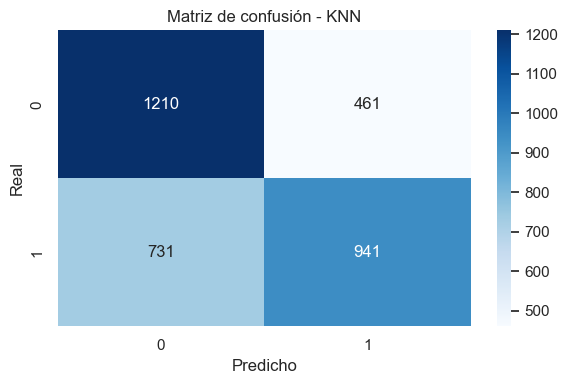

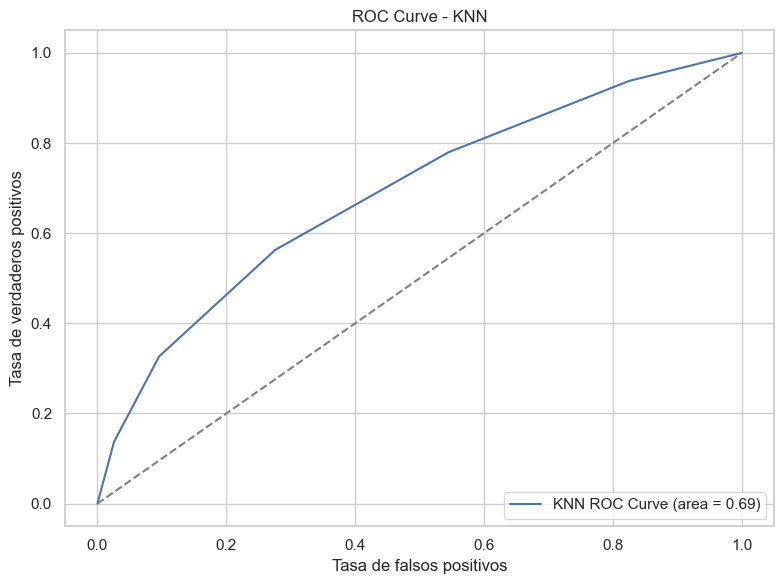

In [17]:
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train_scaled, y_train)

y_pred_knn = knn.predict(X_test_scaled)

print("Classification Report (KNN):\n")
print(classification_report(y_test, y_pred_knn))

cm_knn = confusion_matrix(y_test, y_pred_knn)
plt.figure(figsize=(6, 4))
sns.heatmap(cm_knn, annot=True, fmt='d', cmap='Blues')
plt.title('Matriz de confusión - KNN')
plt.xlabel('Predicho')
plt.ylabel('Real')
plt.tight_layout()
plt.show()

y_prob_knn = knn.predict_proba(X_test_scaled)[:, 1]
fpr_knn, tpr_knn, _ = roc_curve(y_test, y_prob_knn)
roc_auc_knn = auc(fpr_knn, tpr_knn)

plt.figure(figsize=(8, 6))
plt.plot(fpr_knn, tpr_knn, label='KNN ROC Curve (area = %0.2f)' % roc_auc_knn)
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel('Tasa de falsos positivos')
plt.ylabel('Tasa de verdaderos positivos')
plt.title('ROC Curve - KNN')
plt.legend(loc='lower right')
plt.tight_layout()
plt.show()